# Capstone Project: Finding the best venue to open a pizza restaurant in NYC
# By: Jp Soh

<h2> Note: This notebook is used mainly for the capstone project on coursera's IBM Data Science Professional Certification </h2>
<h2> Another Note: Stay safe everyone! Stay at home, eat healthy and learn admidst this crisis </h2>

![alt text](https://m.economictimes.com/thumb/msid-71427663,width-400,height-300,resizemode-4,imgsize-57628/coursera-agencies.jpg "Apple and Green Paper")

## Data Preparation Stage

<strong> Importing the necessary libraries </strong>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# For downloading datasets
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                       

<strong> This cell contains foursquare API credentials and has been removed for sharing </strong>

In [2]:
# The code was removed by Watson Studio for sharing.

<h3> First Dataset: Latitutude and longitude coordinates of each neighborhood </h3>

<strong> Downloading the dataset that contains the 5 boroughs and 306 neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood </strong>

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


<strong> Loading the data and extracing useful information </strong>

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

<strong> Tranform the data into a pandas dataframe </strong>

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Looping and filling te dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


<strong> Examine the resulting dataframe </strong>

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


<strong> Making sure that the dataset has all 5 boroughs and 306 neighborhoods </strong>

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<h3> Second Dataset: Crime statistics on each borough and neighbourhood </h3>

<strong> Downloading the crime dataset </strong>

In [8]:
# The code was removed by Watson Studio for sharing.

<strong> Loading the dataset and extracting only relevant information </strong>

In [9]:
df_crime = pd.read_csv(body)
df_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


<strong> Creating a new dataframe with relevant information used for data analysis </strong>

In [10]:
crime_analysis =df_crime.drop(['CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM','HADEVELOPT','HOUSING_PSA','LOC_OF_OCCUR_DESC','PARKS_NM','STATION_NAME','SUSP_AGE_GROUP','SUSP_RACE','SUSP_RACE','SUSP_SEX','TRANSIT_DISTRICT','VIC_AGE_GROUP','VIC_RACE','VIC_SEX','X_COORD_CD','Y_COORD_CD','Lat_Lon'], axis=1)
crime_analysis.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,Latitude,Longitude
0,314773184,48,BRONX,12/31/2019,COMPLETED,0.0,N.Y. POLICE DEPT,105,FELONY,ROBBERY,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681
1,289837961,25,MANHATTAN,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,40.800334,-73.945657
2,535744284,77,BROOKLYN,12/24/2019,COMPLETED,0.0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,40.669832,-73.939376
3,895678119,52,BRONX,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,40.873671,-73.908014
4,299841674,18,MANHATTAN,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,40.760935,-73.994529


<strong> Convert Borough names into proper function </strong>

In [11]:
crime_analysis['BORO_NM'] = crime_analysis['BORO_NM'].str.title() 
crime_analysis.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,Latitude,Longitude
0,314773184,48,Bronx,12/31/2019,COMPLETED,0.0,N.Y. POLICE DEPT,105,FELONY,ROBBERY,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681
1,289837961,25,Manhattan,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,40.800334,-73.945657
2,535744284,77,Brooklyn,12/24/2019,COMPLETED,0.0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,40.669832,-73.939376
3,895678119,52,Bronx,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,40.873671,-73.908014
4,299841674,18,Manhattan,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,40.760935,-73.994529


<h3> Third Dataset: Population in each borough and neighborhood </h3>

<strong> Downloading the population dataset </strong>

In [12]:
# The code was removed by Watson Studio for sharing.

<strong> Loading and viewing the dataset  </strong>

In [13]:
df_population = pd.read_csv(body)
df_population.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,"28,149"
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,"35,422"
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,"55,329"
3,Bronx,2000,5,BX06,Belmont,"25,967"
4,Bronx,2000,5,BX07,Bronxdale,"34,309"


<strong> Creating a new dataframe with relevant information used for data analysis </strong>

In [14]:
population_analysis =df_population.drop(['FIPS County Code', 'Year','NTA Code','NTA Name'], axis=1)
population_analysis.head()

,Borough,Population
0,Bronx,"28,149"
1,Bronx,"35,422"
2,Bronx,"55,329"
3,Bronx,"25,967"
4,Bronx,"34,309"


<strong> Removing the comma in the population column and set the number in the population column as type integer </strong>

In [15]:
population_analysis['Population'] = population_analysis['Population'].str.replace(',', '')
population_analysis['Population'] = population_analysis['Population'].astype(int)
population_analysis.head()

,Borough,Population
0,Bronx,28149
1,Bronx,35422
2,Bronx,55329
3,Bronx,25967
4,Bronx,34309


# Data Analysis stage

## Choosing the borough 

### First criteria: Using the Crime Data: Which borough has the least crime?

<strong> Finding the number of crime of each borough in the dataset! </strong>

In [16]:
BoroughCountCrime= crime_analysis['BORO_NM'].value_counts(normalize=False, sort=True, ascending=True)
BoroughCountCrime

Staten Island     19019
Queens            92575
Bronx            100994
Manhattan        116352
Brooklyn         132445
Name: BORO_NM, dtype: int64

<strong> We can also view this in relative frequencies </strong>

In [17]:
BoroughCountCrimePercent = crime_analysis['BORO_NM'].value_counts(normalize=True, sort=True, ascending=True)
BoroughCountCrimePercent

Staten Island    0.041222
Queens           0.200646
Bronx            0.218893
Manhattan        0.252180
Brooklyn         0.287060
Name: BORO_NM, dtype: float64

<strong> Convert BoroughCountCrime into a dataframe </strong>

In [18]:
BoroughCountCrime = pd.DataFrame(data=BoroughCountCrime)
BoroughCountCrime

,BORO_NM
Staten Island,19019
Queens,92575
Bronx,100994
Manhattan,116352
Brooklyn,132445


In [19]:
# Do some Data Wranggling
BoroughCountCrime = BoroughCountCrime.reset_index()
BoroughCountCrime.columns = ['Borough','Frequency']
BoroughCountCrime

,Borough,Frequency
0,Staten Island,19019
1,Queens,92575
2,Bronx,100994
3,Manhattan,116352
4,Brooklyn,132445


<strong> Plot a simple bar chart on the frequencies of crime </strong>

In [20]:
CrimeBar = BoroughCountCrime.plot.bar(x='Borough', y='Frequency', rot=0, title='Bar Chart on the frequencies of crime in each borough', figsize=(12,5))
CrimeBar

### Second criteria: Using the population data, which has the highest population?

<strong> Group Population number according to the borough </strong>

In [21]:
population_analysis_grouped = population_analysis.groupby(['Borough'],as_index=False,sort=True).sum()
population_analysis_grouped

,Borough,Population
0,Bronx,2717758
1,Brooklyn,4970026
2,Manhattan,3123068
3,Queens,4460101
4,Staten Island,912458


<strong> Plot a simple pie chart on % of population in each borough relative to the whole population of New York City </strong>

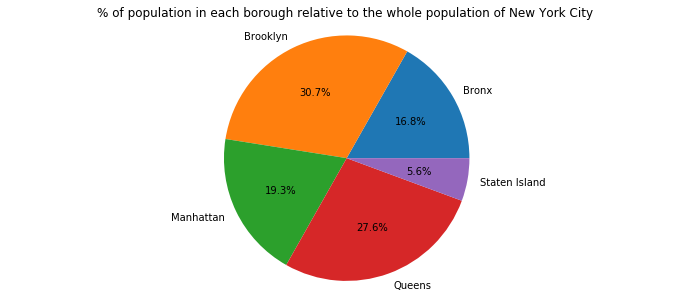

In [22]:
import matplotlib.pyplot as plt
plt.pie(population_analysis_grouped['Population'],labels=population_analysis_grouped['Borough'],autopct='%1.1f%%')
plt.title('% of population in each borough relative to the whole population of New York City')
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.show()

### Deciding the borough

<strong> We create an evaluation table to decide the borough based on the scores concluded from the previous two analysis </strong>

In [23]:
Borough= ['Bronx', 'Brooklyn', 'Manhattan','Queens','Staten Island']
Rating_Population= [2, 5, 3, 4, 1]
Rating_Crime = [3, 1, 2, 4, 5]

data = {'Borough':Borough, 'Population_score':Rating_Population, 'Crime_score':Rating_Crime}
Evaluation_Table = pd.DataFrame(data) 
Evaluation_Table

,Borough,Population_score,Crime_score
0,Bronx,2,3
1,Brooklyn,5,1
2,Manhattan,3,2
3,Queens,4,4
4,Staten Island,1,5


<strong> Adding up the population score and crime score to derive the total score </strong>

In [24]:
Evaluation_Table ["Total"] = Evaluation_Table.sum(axis=1)
Evaluation_Table

,Borough,Population_score,Crime_score,Total
0,Bronx,2,3,5
1,Brooklyn,5,1,6
2,Manhattan,3,2,5
3,Queens,4,4,8
4,Staten Island,1,5,6


<strong> Conclusion: Based on the above analysis, I will choose the borough Queens to be the borough where I will want to open my restaurant in, as it has the highest score </strong>

## Exploring the neighborhoods in Queens (First Dataset)

<strong> Finding the geograpical coordinate of New York City </strong>

In [25]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


<strong> Create a map of New York with neighborhoods superimposed on top </strong>

In [26]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Note: click on each circle mark to reveal the name of the neighborhood and its respective borough

<strong> Create a new dataframe of the Queens data </strong>

In [27]:
Queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
Queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


<strong> Get the geographical coordinates of Queens </strong>

In [28]:
Address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7127281, -74.0060152.


<strong> Create map of Queens using latitude and longitude values with neighborhoods imposed on it </strong>

In [29]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Queens_data['Latitude'], Queens_data['Longitude'], Queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

<strong> Exploring the venues near the neighborhoods </strong>

In [30]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

#create a function that explore venues near the neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Queens_venues = getNearbyVenues(names=Queens_data['Neighborhood'],
                                   latitudes=Queens_data['Latitude'],
                                   longitudes=Queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [31]:
#Checking the size and first 10 rows of the resulting dataframe
print(Queens_venues.shape)
Queens_venues.head(10)

(2088, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
5,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
6,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts Dojo
7,Astoria,40.768509,-73.915654,Zyara Restaurant,40.766591,-73.912713,Mediterranean Restaurant
8,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
9,Astoria,40.768509,-73.915654,SVL Bar,40.769816,-73.918530,Greek Restaurant


In [32]:
#Find how many venues were returned for each neighborhood
Queensgroupby=Queens_venues.groupby('Neighborhood').count()
Queensgroupby

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13
Auburndale,20,20,20,20,20,20
Bay Terrace,37,37,37,37,37,37
Bayside,69,69,69,69,69,69
Bayswater,2,2,2,2,2,2
Beechhurst,12,12,12,12,12,12
Bellaire,14,14,14,14,14,14


In [33]:
# find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Queens_venues['Venue Category'].unique())))

There are 265 uniques categories.


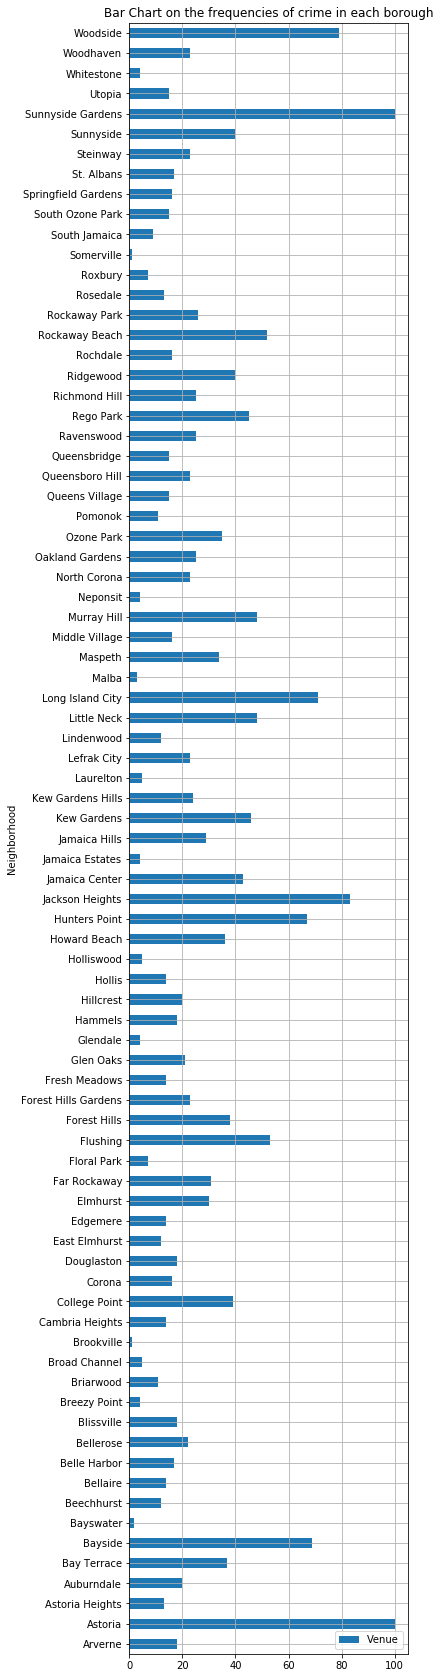

In [34]:
# Find the neighbourhoods with the highest number of venue through visualization: vertical bar chart
QueensCountBar = Queensgroupby.plot.barh(y='Venue', rot=0, title='Bar Chart on the frequencies of crime in each borough',figsize=(5,30),grid=True)
QueensCountBar

<h4> Top 5 Neighborhoods to choose based on the number of venues in the neighborhoods </h4>
<h4></h4>
<li>Sunnyside Gardens</li>
<li>Astoria</li>
<li>Jackson Heights</li>
<li>Woodside</li>
<li>Long Island City</li>


In [35]:
# Create a list to store the top 5 neighborhoods
list_top5=['Sunnyside Gardens','Astoria','Jackson Heights','Woodside','Long Island City']

<strong> Analysising each neighbourhood </strong>

In [36]:
# one hot encoding
Queens_onehot = pd.get_dummies(Queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Queens_onehot['Neighborhood'] = Queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Queens_onehot.columns[-1]] + list(Queens_onehot.columns[:-1])
Queens_onehot = Queens_onehot[fixed_columns]

Queens_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [37]:
# Checking the size of the resulting dataframe
Queens_onehot.shape

(2088, 265)

In [38]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Queens_grouped = Queens_onehot.groupby('Neighborhood').mean().reset_index()
Queens_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Arverne,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.

In [39]:
# Size of grouped dataframe
Queens_grouped.shape

(81, 265)

In [40]:
# Print each neighborhood along with the top 5 most common venue category

num_top_venues = 5

for hood in Queens_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Queens_grouped[Queens_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
             venue  freq
0        Surf Spot  0.22
1    Metro Station  0.11
2   Sandwich Place  0.11
3      Coffee Shop  0.06
4  Bed & Breakfast  0.06


----Astoria----
                       venue  freq
0                        Bar  0.07
1  Middle Eastern Restaurant  0.06
2           Greek Restaurant  0.05
3                 Hookah Bar  0.05
4   Mediterranean Restaurant  0.04


----Astoria Heights----
           venue  freq
0  Deli / Bodega  0.08
1    Pizza Place  0.08
2    Bus Station  0.08
3  Bowling Alley  0.08
4    Supermarket  0.08


----Auburndale----
                venue  freq
0  Italian Restaurant  0.10
1       Deli / Bodega  0.05
2            Pharmacy  0.05
3   Mobile Phone Shop  0.05
4  Miscellaneous Shop  0.05


----Bay Terrace----
                 venue  freq
0       Clothing Store  0.11
1        Women's Store  0.05
2  American Restaurant  0.05
3           Shoe Store  0.05
4           Donut Shop  0.05


----Bayside----
                 venue  freq
0         

In [41]:
# write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
# create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Queens_grouped['Neighborhood']

for ind in np.arange(Queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Sandwich Place,Metro Station,Pizza Place,Coffee Shop,Board Shop,Bus Stop,Bed & Breakfast,Beach,Thai Restaurant
1,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Mediterranean Restaurant,Seafood Restaurant,Indian Restaurant,Italian Restaurant,Food Truck,Ice Cream Shop
2,Astoria Heights,Burger Joint,Bowling Alley,Laundromat,Bakery,Supermarket,Italian Restaurant,Deli / Bodega,Bus Station,Pizza Place,Shopping Mall
3,Auburndale,Italian Restaurant,Noodle House,Miscellaneous Shop,Furniture / Home Store,Sushi Restaurant,Bar,Discount Store,Athletics & Sports,Supermarket,Mobile Phone Shop
4,Bay Terrace,Clothing Store,Women's Store,Kids Store,Donut Shop,Mobile Phone Shop,Shoe Store,Lingerie Store,Cosmetics Shop,American Restaurant,Video Game Store


In [50]:
# Find out which Neighborhood have pizza place as top 10
Contains_pizza = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains("Pizza Place") | neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['4th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['5th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['6th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['7th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['8th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['9th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['10th Most Common Venue'].str.contains("Pizza Place") ] 
Contains_pizza

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Sandwich Place,Metro Station,Pizza Place,Coffee Shop,Board Shop,Bus Stop,Bed & Breakfast,Beach,Thai Restaurant
2,Astoria Heights,Burger Joint,Bowling Alley,Laundromat,Bakery,Supermarket,Italian Restaurant,Deli / Bodega,Bus Station,Pizza Place,Shopping Mall
5,Bayside,Bar,Pizza Place,Sushi Restaurant,American Restaurant,Indian Restaurant,Pub,Bakery,Spa,Greek Restaurant,Ice Cream Shop
10,Bellerose,Pizza Place,Deli / Bodega,Italian Restaurant,Bank,Grocery Store,Bus Station,Flower Shop,Motel,Seafood Restaurant,Gas Station
14,Broad Channel,Sporting Goods Shop,Pizza Place,Other Nightlife,Dive Bar,Deli / Bodega,Women's Store,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant
17,College Point,Deli / Bodega,Asian Restaurant,Pizza Place,Latin American Restaurant,Bakery,Karaoke Bar,Hotel,Steakhouse,Spanish Restaurant,Spa
18,Corona,Mexican Restaurant,Pizza Place,Italian Restaurant,Empanada Restaurant,Supermarket,Sandwich Place,Donut Shop,Bakery,Chinese Restaurant,Restaurant
21,Edgemere,Metro Station,Pizza Place,Asian Restaurant,Deli / Bodega,Park,Scenic Lookout,Seafood Restaurant,Bus Station,Farm,Skate Park
22,Elmhurst,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Colombian Restaurant,Pizza Place,Park,Donut Shop,Snack Place
23,Far Rockaway,Pizza Place,Deli / Bodega,Fried Chicken Joint,Grocery Store,Supermarket,Breakfast Spot,Chinese Restaurant,Bank,Metro Station,Fast Food Restaurant


In [57]:
# Check whether the Top 5 Neighborhoods that are choosen based on the number of venues has pizza venue as its top 10 venue 
for x in list_top5:
    for y in Contains_pizza['Neighborhood']:
        if x == y:
            print(x)
    

Sunnyside Gardens
Woodside
Long Island City


<h4> Conclusion: Since Sunnyside Gardens, Woodside and Long Island City has pizza places as their top 10 venues, it will be unwise to open a pizza restaurant in these neighbourhoods as there are many competitors in the area. Instead, we can open at either Astoria or Jackson Heights. Since Astoria has a higher number of venues than Jackson Heights, it will be good to open there as it generally indicates the neighborhood is more popular. </h4>

## Understanding and Clustering Queens' neighbourhood using K-Means

It will not hurt to understand other neighborh

In [58]:
# set number of clusters
kclusters = 10

Queens_grouped_clustering = Queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 1, 2, 2, 2, 4, 1, 2, 8], dtype=int32)

<strong> create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood </strong>

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Queens_merged = Queens_data

# merge NY_grouped with NY_data to add latitude/longitude for each neighborhood
Queens_merged = Queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Queens_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,2,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Mediterranean Restaurant,Seafood Restaurant,Indian Restaurant,Italian Restaurant,Food Truck,Ice Cream Shop
1,Queens,Woodside,40.746349,-73.901842,2,Grocery Store,Thai Restaurant,Bakery,Filipino Restaurant,Latin American Restaurant,Pizza Place,American Restaurant,Deli / Bodega,Donut Shop,Bar
2,Queens,Jackson Heights,40.751981,-73.882821,2,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Mexican Restaurant,Mobile Phone Shop,Thai Restaurant,Grocery Store,Colombian Restaurant,Diner
3,Queens,Elmhurst,40.744049,-73.881656,2,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Colombian Restaurant,Pizza Place,Park,Donut Shop,Snack Place
4,Queens,Howard Beach,40.654225,-73.838138,2,Italian Restaurant,Pharmacy,Bagel Shop,Clothing Store,Sandwich Place,Fast Food Restaurant,Shipping Store,Sushi Restaurant,Japanese Restaurant,Jewelry Store


<strong> Cleaning the dataframe to omit any NaN Values and set cluster label as an integer </strong>

In [60]:
# Finding Neighborhoods that has null values. 
print(Queens_merged[Queens_merged['1st Most Common Venue'].isnull()])

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []


In [61]:
# Drop Neighborhood: Howland Hook that has most of its values NaN. Since there are no NaN values, we do not need to run this cell
# Queens_merged = Queens_merged.dropna(subset=['1st Most Common Venue'])

In [62]:
# Change the data type of the column cluster label to integer (in case)
Queens_merged['Cluster Labels'] = Queens_merged['Cluster Labels'].astype(int)

<strong> Create a folium map to visualize the resulting cluster  </strong>

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Queens_merged['Latitude'],Queens_merged['Longitude'], Queens_merged['Neighborhood'], Queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

<strong> Cluster 1 </strong>

In [66]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 0, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,St. Albans,Caribbean Restaurant,Café,Chinese Restaurant,Donut Shop,Grocery Store,Fried Chicken Joint,Discount Store,Shopping Mall,Market,Fast Food Restaurant
39,Cambria Heights,Caribbean Restaurant,Bakery,Moving Target,Chinese Restaurant,Nightclub,Jewelry Store,Liquor Store,Restaurant,Gym / Fitness Center,Pharmacy
59,Laurelton,Caribbean Restaurant,Sculpture Garden,Park,Train Station,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Women's Store


<strong> Cluster 2 </strong>

In [67]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 1, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Corona,Mexican Restaurant,Pizza Place,Italian Restaurant,Empanada Restaurant,Supermarket,Sandwich Place,Donut Shop,Bakery,Chinese Restaurant,Restaurant
11,Sunnyside,Pizza Place,Bakery,Italian Restaurant,South American Restaurant,Hotel,Discount Store,Chinese Restaurant,Coffee Shop,Clothing Store,Diner
15,Glendale,Food & Drink Shop,Brewery,Pizza Place,Arts & Crafts Store,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant
21,Whitestone,Bubble Tea Shop,Dance Studio,Deli / Bodega,Candy Store,Women's Store,Farm,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant
27,Bellerose,Pizza Place,Deli / Bodega,Italian Restaurant,Bank,Grocery Store,Bus Station,Flower Shop,Motel,Seafood Restaurant,Gas Station
28,Kew Gardens Hills,Bank,Bus Station,Playground,Sushi Restaurant,Pizza Place,Smoke Shop,Eastern European Restaurant,Wine Bar,Restaurant,Bagel Shop
30,Briarwood,Playground,Indian Restaurant,Convenience Store,Fast Food Restaurant,Bus Station,Sushi Restaurant,Coffee Shop,Arts & Crafts Store,Mexican Restaurant,Deli / Bodega
35,South Jamaica,Bus Station,Supermarket,Caribbean Restaurant,Grocery Store,Sandwich Place,Vegetarian / Vegan Restaurant,Bakery,Falafel Restaurant,Farm,Farmers Market
41,Far Rockaway,Pizza Place,Deli / Bodega,Fried Chicken Joint,Grocery Store,Supermarket,Breakfast Spot,Chinese Restaurant,Bank,Metro Station,Fast Food Restaurant
42,Broad Channel,Sporting Goods Shop,Pizza Place,Other Nightlife,Dive Bar,Deli / Bodega,Women's Store,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant


<strong> Cluster 3 </strong>

In [68]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 2, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Mediterranean Restaurant,Seafood Restaurant,Indian Restaurant,Italian Restaurant,Food Truck,Ice Cream Shop
1,Woodside,Grocery Store,Thai Restaurant,Bakery,Filipino Restaurant,Latin American Restaurant,Pizza Place,American Restaurant,Deli / Bodega,Donut Shop,Bar
2,Jackson Heights,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Mexican Restaurant,Mobile Phone Shop,Thai Restaurant,Grocery Store,Colombian Restaurant,Diner
3,Elmhurst,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Colombian Restaurant,Pizza Place,Park,Donut Shop,Snack Place
4,Howard Beach,Italian Restaurant,Pharmacy,Bagel Shop,Clothing Store,Sandwich Place,Fast Food Restaurant,Shipping Store,Sushi Restaurant,Japanese Restaurant,Jewelry Store
6,Forest Hills,Gym,Gym / Fitness Center,Yoga Studio,Pharmacy,Pizza Place,Park,Thai Restaurant,Convenience Store,Video Game Store,Italian Restaurant
7,Kew Gardens,Chinese Restaurant,Cosmetics Shop,Indian Restaurant,Donut Shop,Pizza Place,Deli / Bodega,Bank,Bar,Park,Fried Chicken Joint
8,Richmond Hill,Pizza Place,Lounge,Latin American Restaurant,Bank,Discount Store,Bus Line,Spanish Restaurant,Moving Target,Supermarket,Sandwich Place
9,Flushing,Hotpot Restaurant,Bakery,Bubble Tea Shop,Chinese Restaurant,Korean Restaurant,Sushi Restaurant,Gym,Gym / Fitness Center,Karaoke Bar,Construction & Landscaping
10,Long Island City,Hotel,Coffee Shop,Bar,Pizza Place,Gym / Fitness Center,Café,Mexican Restaurant,Donut Shop,Deli / Bodega,Food Truck


<strong> Cluster 4 </strong>

In [69]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 3, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Somerville,Park,Women's Store,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Farm,Dosa Place


<strong> Cluster 5 </strong>

In [70]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 4, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Bayswater,Playground,Park,Women's Store,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market


<strong> Cluster 6 </strong>

In [71]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 5, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Murray Hill,Korean Restaurant,Supermarket,Coffee Shop,Bar,Bank,Pet Service,Breakfast Spot,Karaoke Bar,Bath House,Japanese Restaurant


<strong> Cluster 7 </strong>

In [72]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 6, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Brookville,Deli / Bodega,Women's Store,Farmers Market,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant


<strong> Cluster 8 </strong>

In [73]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 7, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Neponsit,Beach,Women's Store,Eastern European Restaurant,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


<strong> Cluster 9 </strong>

In [74]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 8, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Breezy Point,Beach,Monument / Landmark,Trail,Supermarket,Women's Store,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant
49,Rockaway Beach,Beach,Ice Cream Shop,Food Truck,Arepa Restaurant,BBQ Joint,Bagel Shop,Seafood Restaurant,Pizza Place,Latin American Restaurant,Poke Place
61,Belle Harbor,Beach,Spa,Deli / Bodega,Pub,Chinese Restaurant,Italian Restaurant,Boutique,Bakery,Bagel Shop,Donut Shop
75,Roxbury,Baseball Field,Beach,Deli / Bodega,Fast Food Restaurant,Trail,Irish Pub,Women's Store,Farm,Empanada Restaurant,Event Space
78,Hammels,Beach,Fried Chicken Joint,Bus Stop,Café,Building,Deli / Bodega,Fast Food Restaurant,Bus Station,Diner,Shoe Store


<strong> Cluster 10 </strong>

In [75]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 9, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Malba,Vegetarian / Vegan Restaurant,Rest Area,Tennis Court,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Donut Shop


----------------------------------------------------------            <strong> End of notebook </strong> --------------------------------------------------------------------------------

Link to notebook with folium maps: https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/d23a3387-2246-4a56-990e-ba9e415bf584/view?access_token=af78c1a14384eca34b9634e3f09bb6ac1c4b2efb04c5f70421698a2c81e695fc